In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import re
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import string
from random import sample
import pickle

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df1 = pd.read_csv('train.csv', encoding = 'ISO-8859-1')

In [4]:
df1.shape

(1599999, 6)

In [5]:
df1.columns =['class', 'id', 'date', 'query','user','tweet']

In [6]:
df = df1.sample(n=80000)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 1284847 to 1488654
Data columns (total 6 columns):
class    80000 non-null int64
id       80000 non-null int64
date     80000 non-null object
query    80000 non-null object
user     80000 non-null object
tweet    80000 non-null object
dtypes: int64(2), object(4)
memory usage: 4.3+ MB


In [8]:
df.head()

,class,id,date,query,user,tweet
1284847,4,2002084895,Tue Jun 02 03:05:28 PDT 2009,NO_QUERY,Muzzzza,@ExocetAU you have a cane?
310464,0,2001106744,Mon Jun 01 23:51:41 PDT 2009,NO_QUERY,Joooooe,Another Cracking Day N A Stuck In This Shity C...
147606,0,1882850190,Fri May 22 07:35:30 PDT 2009,NO_QUERY,ItsMissKaye,@tophenyx dont rub it in that you get to take ...
1302519,4,2008444947,Tue Jun 02 14:08:30 PDT 2009,NO_QUERY,Itxi_Itx,@Eyglo Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´hhhh that WOU...
500827,0,2186975714,Mon Jun 15 19:36:31 PDT 2009,NO_QUERY,MileyQ,"I miss ashley , bouda grab some frosted flakess"


In [9]:
df['query'].value_counts()

NO_QUERY    80000
Name: query, dtype: int64

class = 0(neg),1(pos)

In [10]:
df['class'].value_counts()

4    40188
0    39812
Name: class, dtype: int64

In [11]:
df['class'] = df['class'].replace(4,1)

In [12]:
df['length'] = df['tweet'].apply(len)

In [13]:
qids = pd.Series(df['tweet'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Tweet are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique tweet that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single tweet is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Tweet are: 79784

Number of unique tweet that appear more than one time: 134 (0.16795347438082825%)

Max number of times a single tweet is repeated: 9



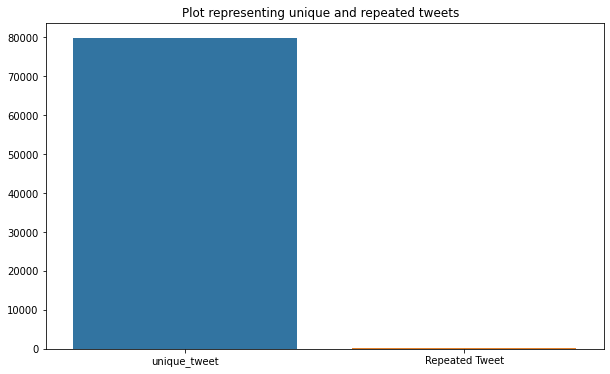

In [14]:
x = ["unique_tweet" , "Repeated Tweet"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated tweets  ")
sns.barplot(x,y)
plt.show()

# Pre-processing

- Preprocessing
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [15]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return [x]
    

In [16]:
def preprocess2(mess):
    no_punctuation = [char for char in mess if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return [word for word in no_punctuation.split() if word.lower() 
            not in stopwords.words('english')]

In [17]:
# https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
neg = []
pos = []
neu = []
compound = []

for a in tqdm(df['tweet']) :
    b = sid.polarity_scores(a)['neg']
    c = sid.polarity_scores(a)['pos']
    d = sid.polarity_scores(a)['neu']
    e = sid.polarity_scores(a)['compound']
    neg.append(b)
    pos.append(c)
    neu.append(d)
    compound.append(e)
df["pos"] = pos
df["neg"] = neg
df["neu"] = neu
df["compound"] = compound

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 80000/80000 [01:04<00:00, 1242.70it/s]


In [18]:
x = df.iloc[:,5:]

In [19]:
x.head()

,tweet,length,pos,neg,neu,compound
1284847,@ExocetAU you have a cane?,27,0.000,0.000,1.000,0.0000
310464,Another Cracking Day N A Stuck In This Shity C...,109,0.128,0.092,0.780,0.2023
147606,@tophenyx dont rub it in that you get to take ...,100,0.116,0.000,0.884,0.3578
1302519,@Eyglo Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´Ã´hhhh that WOU...,96,0.275,0.000,0.725,0.5838
500827,"I miss ashley , bouda grab some frosted flakess",48,0.000,0.211,0.789,-0.1531


# Splitting data

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,df['class'] , test_size = 0.3)

In [21]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)
print("Number of data points in train data :",y_train.shape)
print("Number of data points in test data :",y_test.shape)

Number of data points in train data : (56000, 6)
Number of data points in test data : (24000, 6)
Number of data points in train data : (56000,)
Number of data points in test data : (24000,)


# Apply CountVectorizer

In [22]:
words = CountVectorizer()
words.fit(df['tweet'].values)

CountVectorizer()

In [23]:
#words.shape

In [24]:
bagwords = words.transform(X_train['tweet'].values)
bagwords_test = words.transform(X_test['tweet'].values)

In [25]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['length'].values.reshape(1,-1))

train_length_norm = normalizer.transform(X_train['length'].values.reshape(1,-1))
test_length_norm = normalizer.transform(X_test['length'].values.reshape(1,-1))

train_length_norm=train_length_norm.reshape(-1,1)
test_length_norm=test_length_norm.reshape(-1,1)

In [26]:

normalizer.fit(X_train['pos'].values.reshape(1,-1))

train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(1,-1))
test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(1,-1))

train_pos_norm=train_pos_norm.reshape(-1,1)
test_pos_norm=test_pos_norm.reshape(-1,1)

In [27]:

normalizer.fit(X_train['neg'].values.reshape(1,-1))

train_neg_norm = normalizer.transform(X_train['neg'].values.reshape(1,-1))
test_neg_norm = normalizer.transform(X_test['neg'].values.reshape(1,-1))

train_neg_norm=train_neg_norm.reshape(-1,1)
test_neg_norm=test_neg_norm.reshape(-1,1)


In [28]:

normalizer.fit(X_train['neu'].values.reshape(1,-1))

train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(1,-1))
test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(1,-1))

train_neu_norm=train_neu_norm.reshape(-1,1)
test_neu_norm=test_neu_norm.reshape(-1,1)


In [29]:

normalizer.fit(X_train['compound'].values.reshape(1,-1))

train_compound_norm = normalizer.transform(X_train['compound'].values.reshape(1,-1))
test_compound_norm = normalizer.transform(X_test['compound'].values.reshape(1,-1))

train_compound_norm=train_compound_norm.reshape(-1,1)
test_compound_norm=test_compound_norm.reshape(-1,1)


In [30]:
print(bagwords.shape)
print(bagwords_test.shape)
print(y_train.shape)
print(y_test.shape)


(56000, 82548)
(24000, 82548)
(56000,)
(24000,)


In [31]:
from scipy.sparse import hstack
tr = hstack((bagwords,train_length_norm,train_compound_norm,train_neu_norm,train_neg_norm,train_pos_norm)).tocsr()
te = hstack((bagwords_test,test_length_norm,test_compound_norm,test_neu_norm,test_neg_norm,test_pos_norm)).tocsr()

print("Final Data matrix")
print(tr.shape, y_train.shape)
print(te.shape)

Final Data matrix
(56000, 82553) (56000,)
(24000, 82553)


# apply tfidf

In [32]:
#tfidf_transformer = TfidfTransformer().fit(X_train)

In [33]:
#tweet_tfidf = tfidf_transformer.transform(X_train)
#tweet_tfidf_test = tfidf_transformer.transform(X_test)


In [34]:
#print(tweet_tfidf.shape)
#print(tweet_tfidf_test.shape)

#print(tweet_tfidf)

# Apply Logistic regression

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import math

LR=LogisticRegression()
para={'C' : [0.0001,0.001,0.01,0.1,1,10,100]}
clf = GridSearchCV(LR, para, cv=10, scoring='roc_auc',return_train_score=True)
clf.fit(tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)


E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

100%|██████████| 7/7 [00:00<?, ?it/s]


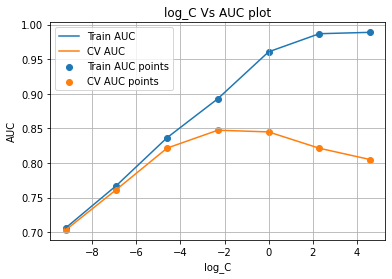

In [36]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
C = [0.0001,0.001,0.01,0.1,1,10,100]
log_C=[]
for a in tqdm(C):
    b = math.log(a)
    log_C.append(b)
plt.plot(log_C, train_auc, label='Train AUC')
plt.plot(log_C, cv_auc, label='CV AUC')
plt.scatter(log_C, train_auc, label='Train AUC points')
plt.scatter(log_C, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log_C")
plt.ylabel("AUC")
plt.title("log_C Vs AUC plot")
plt.grid()
plt.show()

In [37]:
a = clf.best_estimator_
a

LogisticRegression(C=0.1)

In [38]:
LogR=LogisticRegression(C=0.1)

In [39]:
#training the train data
LogR.fit(tr, y_train)

E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.1)

In [40]:
pred = LogR.predict(te)
pred2 = LogR.predict(tr)

In [41]:
pred.shape

(24000,)

In [42]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred, pos_label=1)

# roc curve for tpr = fpr 
#random_probs = [0 for i in range(len(y_test))]
#p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [43]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred)
auc_score2 = roc_auc_score(y_train, pred2)

print('Test AUC Score',auc_score1)
print('Train AUC Score',auc_score2)

Test AUC Score 0.7793905760413009
Train AUC Score 0.8182493184757721


In [44]:

from sklearn.metrics import confusion_matrix

print(metrics.classification_report(y_test, pred))

print(metrics.confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77     11881
           1       0.77      0.80      0.79     12119

    accuracy                           0.78     24000
   macro avg       0.78      0.78      0.78     24000
weighted avg       0.78      0.78      0.78     24000

[[9029 2852]
 [2438 9681]]


# Saving model to disk

In [45]:
#pickle.dump(LogR, open('model.pkl','wb'))

# Loading model to compare results

In [47]:
#model = pickle.load(open('model.pkl','rb'))


In [48]:
# Creating a pickle file for the Multinomial Naive Bayes model
filename = 'model.pkl'
pickle.dump(LogR, open(filename, 'wb'))